# Laboratorio 1 (AlpesHearth): Exploración, preparación y regresión lineal

Este notebook está diseñado para **resolver el enunciado completo** del Laboratorio 1, siguiendo el estilo y las ideas de:
- `ManipulacionExploracionCalidad.ipynb` (exploración + calidad: completitud, unicidad, consistencia, validez)
- `LimpiezaTransformacion.ipynb` (limpieza + transformación)
- `RegresionLineal.ipynb` (pipeline, métricas, y verificación de supuestos)

**Objetivo técnico del laboratorio:** predecir `CVD Risk Score` (variable continua) con modelos de regresión lineal, comparar al menos 2 estrategias de preparación, interpretar coeficientes del mejor modelo y generar predicciones para el set de test no etiquetado.

Nota de compatibilidad: `Datos Lab 1.csv` usa separador `,` y `Datos Test Lab 1.csv` usa separador `;`. Este notebook lo maneja automáticamente.


## 0. Imports y constantes

Qué haces aquí: importar librerías y fijar constantes exigidas por el enunciado.

Por qué existe esta celda: evita imports repetidos y hace explícitos los parámetros obligatorios: `random_state=42` y `test_size=0.25`.


In [22]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.base import BaseEstimator, TransformerMixin

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

RANDOM_STATE = 42
TEST_SIZE = 0.25

TARGET = "CVD Risk Score"
AUX_LABEL = "CVD Risk Level"


## 1. Cargar datos (train, test) y diccionario

Qué haces aquí:
1. Leer los CSV de train y test detectando separador automáticamente.
2. Leer el diccionario en Excel para entender el significado de las columnas.

Por qué existe esta celda:
- El enunciado exige revisar el diccionario primero.
- Si lees el test con separador incorrecto, todo el notebook falla.


In [23]:

def read_csv_auto_sep(path: str) -> pd.DataFrame:
    # Detecta si el separador es ; o , leyendo la primera línea del archivo
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        first_line = f.readline()
    sep = ";" if first_line.count(";") > first_line.count(",") else ","
    return pd.read_csv(path, sep=sep)

train_path = "Datos Lab 1.csv"
test_path  = "Datos Test Lab 1.csv"
dicc_path  = "DiccPacientes.xlsx"

train_raw = read_csv_auto_sep(train_path)
test_raw  = read_csv_auto_sep(test_path)
dicc_raw  = pd.read_excel(dicc_path)

# El diccionario trae el nombre de columna con un espacio final, lo normalizamos.
dicc = dicc_raw.copy()
dicc.columns = [c.strip() for c in dicc.columns]

print("Train shape:", train_raw.shape)
print("Test  shape:", test_raw.shape)
display(dicc.head(10))

# Validación rápida: train debe tener target, test no.
print("Columnas extra en train (vs test):", sorted(list(set(train_raw.columns) - set(test_raw.columns))))


Train shape: (1639, 24)
Test  shape: (194, 22)


,Nombre Columna,Tipo de dato,Comentarios
0,Patient ID,String,Identificador del paciente
1,Date of Service,Date,Fecha de la atención
2,Sex,String,"Sexo (Femenino, Masculino)"
3,Age,Integer,Edad
4,Weight (kg),Float,Peso
5,Height (m),Float,Altura
6,BMI,Float,Índice de masa corporal
7,Abdominal Circumference (cm),Float,Circunferencia abdominal
8,Blood Pressure (mmHg),String,"Presión sanguínea, de la forma ""<Presión arter..."
9,Total Cholesterol (mg/dL),Float,Colesterol total


Columnas extra en train (vs test): ['CVD Risk Level', 'CVD Risk Score']


## 2. Exploración inicial (descripción básica)

Qué haces aquí:
- Mirar primeras filas (`head`), tipos (`dtypes`) y resumen estadístico (`describe`).

Por qué existe esta celda:
- Es el punto de partida para detectar problemas de calidad y decidir preparación.
- Esto sigue el enfoque de "Descripción de los datos" en los notebooks guía.


In [24]:

display(train_raw.head())
display(test_raw.head())

print("Tipos de datos (train):")
display(train_raw.dtypes)

print("Describe numérico (train):")
display(train_raw.select_dtypes(include=[np.number]).describe())

print("Describe del target (train):")
display(train_raw[TARGET].describe())


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
0,isDx5313,"November 08, 2023",M,44.0,114.300,1.720,38.600,100.000,112/83,228.0,77.0,91.0,Y,Y,High,N,172.000,0.581,112.0,83.0,Hypertension Stage 1,121.0,19.880,HIGH
1,LHCK2961,20/03/2024,F,57.0,92.923,1.842,33.116,106.315,101/91,158.0,71.0,76.0,N,Y,High,Y,184.172,0.577,101.0,91.0,Hypertension Stage 2,57.0,16.833,INTERMEDIARY
2,WjVn1699,2021-05-27,F,NaN,73.400,1.650,27.000,78.100,90/74,135.0,60.0,150.0,N,N,High,N,165.000,0.473,90.0,74.0,Normal,45.0,12.600,LOW
3,dCDO1109,"April 18, 2022",F,35.0,113.300,1.780,35.800,79.600,92/89,158.0,34.0,111.0,Y,N,Moderate,Y,178.000,0.447,92.0,89.0,Hypertension Stage 1,94.0,14.920,HIGH
4,pnpE1080,01/11/2024,F,48.0,102.200,1.750,33.400,106.700,121/68,207.0,49.0,147.0,Y,Y,Low,Y,175.000,0.610,121.0,68.0,Elevated,128.0,18.870,HIGH


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL)
0,WYTG8678,1/12/2021,M,44.0,51.936,1.936,36.442,115.755,105/108,107.0,52.0,125.0,Y,Y,Low,N,193.61,0.598,105.0,108.0,Hypertension Stage 2,25.0
1,yloc1993,12-25-2020,F,30.0,115.000,1.830,34.300,93.600,139/79,100.0,31.0,125.0,Y,N,Moderate,N,183.00,0.511,139.0,79.0,Hypertension Stage 1,39.0
2,DDwq7653,23-sep-21,M,38.0,63.300,1.700,21.900,93.800,93/67,NaN,76.0,73.0,N,Y,High,N,170.00,0.552,93.0,67.0,Normal,182.0
3,YTcX6704,3/03/2021,F,58.0,72.300,1.740,23.900,91.600,99/90,208.0,63.0,114.0,N,N,High,N,174.00,0.526,99.0,90.0,Hypertension Stage 2,115.0
4,lZLi8935,06-14-2022,M,51.0,57.600,1.810,17.600,100.000,97/84,137.0,48.0,113.0,Y,N,High,N,181.00,0.552,97.0,84.0,Hypertension Stage 1,59.0


Tipos de datos (train):


Patient ID                          str
Date of Service                     str
Sex                                 str
Age                             float64
Weight (kg)                     float64
Height (m)                      float64
BMI                             float64
Abdominal Circumference (cm)    float64
Blood Pressure (mmHg)               str
Total Cholesterol (mg/dL)       float64
HDL (mg/dL)                     float64
Fasting Blood Sugar (mg/dL)     float64
Smoking Status                      str
Diabetes Status                     str
Physical Activity Level             str
Family History of CVD               str
Height (cm)                     float64
Waist-to-Height Ratio           float64
Systolic BP                     float64
Diastolic BP                    float64
Blood Pressure Category             str
Estimated LDL (mg/dL)           float64
CVD Risk Score                  float64
CVD Risk Level                      str
dtype: object

Describe numérico (train):


,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),CVD Risk Score
count,1571.000000,1566.000000,1578.000000,1586.000000,1578.000000,1571.000000,1557.000000,1585.000000,1571.000000,1563.000000,1578.000000,1554.000000,1582.000000,1610.000000
mean,46.803186,85.666006,1.757439,28.424744,91.538861,199.043673,56.183558,117.836860,175.770082,0.522440,125.632637,82.887536,113.235896,18.227281
std,13.039479,21.712504,0.118012,7.309275,13.427985,59.388670,16.721702,32.379634,11.695880,0.085692,22.577463,15.503625,61.435291,10.767666
min,6.134000,13.261000,1.371000,4.317000,49.542000,-1.256000,0.008000,15.306000,136.498000,0.250000,49.914000,31.720000,-92.055000,-20.057000
25%,37.000000,67.100000,1.666500,22.600000,79.700000,150.000000,42.000000,92.000000,167.000000,0.453000,108.000000,71.000000,62.000000,15.150000
50%,46.000000,86.314000,1.760000,28.000000,91.200000,199.000000,56.000000,115.000000,176.000000,0.519000,125.000000,82.000000,112.000000,16.967000
75%,55.000000,104.801500,1.850000,33.963000,102.267250,250.000000,70.000000,139.000000,185.000000,0.582000,141.000000,93.000000,159.000000,18.900000
max,89.420000,158.523000,2.146000,53.028000,136.336000,385.679000,110.315000,219.667000,214.394000,0.804000,202.711000,134.066000,317.314000,114.980000


Describe del target (train):


count    1610.000000
mean       18.227281
std        10.767666
min       -20.057000
25%        15.150000
50%        16.967000
75%        18.900000
max       114.980000
Name: CVD Risk Score, dtype: float64

## 3. Calidad de datos (completitud, unicidad, consistencia, validez)

Esta sección replica el esquema de los notebooks:
- Completitud: porcentaje de faltantes por columna.
- Unicidad: duplicados exactos.
- Consistencia: categorías con formatos incoherentes (mayúsculas, espacios, etc).
- Validez: valores imposibles o fuera de rango lógico (por ejemplo LDL negativo).

La salida de esta sección es la base para justificar tus decisiones de limpieza.


### 3.1 Completitud (missing values)

Qué haces: calculas el porcentaje de faltantes por columna.

Por qué: si tienes faltantes, debes decidir si imputas, corriges usando otras columnas (por ejemplo BP), o eliminas filas (por ejemplo si falta el target).


In [25]:

missing_train = (train_raw.isna().mean() * 100).sort_values(ascending=False)
missing_test  = (test_raw.isna().mean() * 100).sort_values(ascending=False)

print("Missing % (train) - top 15")
display(missing_train.head(15))

print("Missing % (test) - top 15")
display(missing_test.head(15))

print("Filas en train con target missing:", train_raw[TARGET].isna().sum())


Missing % (train) - top 15


Diastolic BP                    5.186089
HDL (mg/dL)                     5.003051
Waist-to-Height Ratio           4.636974
Weight (kg)                     4.453935
Height (cm)                     4.148871
Age                             4.148871
Total Cholesterol (mg/dL)       4.148871
Height (m)                      3.721782
Abdominal Circumference (cm)    3.721782
Systolic BP                     3.721782
Estimated LDL (mg/dL)           3.477730
Fasting Blood Sugar (mg/dL)     3.294692
BMI                             3.233679
CVD Risk Score                  1.769372
Patient ID                      0.000000
dtype: float64

Missing % (test) - top 15


Age                             5.670103
Weight (kg)                     5.154639
BMI                             4.123711
HDL (mg/dL)                     4.123711
Height (cm)                     3.608247
Height (m)                      3.608247
Abdominal Circumference (cm)    3.608247
Systolic BP                     3.092784
Total Cholesterol (mg/dL)       3.092784
Waist-to-Height Ratio           3.092784
Fasting Blood Sugar (mg/dL)     2.577320
Diastolic BP                    2.577320
Estimated LDL (mg/dL)           2.577320
Diabetes Status                 0.000000
Physical Activity Level         0.000000
dtype: float64

Filas en train con target missing: 29


### 3.2 Unicidad (duplicados)

Qué haces: cuentas duplicados exactos (filas idénticas).

Por qué: duplicados exactos pueden sesgar el entrenamiento porque repites el mismo ejemplo varias veces.


In [26]:

dup_train = train_raw.duplicated().sum()
dup_test  = test_raw.duplicated().sum()

print("Duplicados exactos train:", dup_train)
print("Duplicados exactos test :", dup_test)


Duplicados exactos train: 151
Duplicados exactos test : 5


### 3.3 Consistencia (categóricas)

Qué haces: revisas `value_counts()` de columnas categóricas.

Por qué: detecta espacios al inicio/final, mezcla de mayúsculas/minúsculas o etiquetas duplicadas con distinto formato. La regla general es normalizar (strip y formato consistente).


In [27]:

cat_cols = [
    "Sex",
    "Smoking Status",
    "Diabetes Status",
    "Physical Activity Level",
    "Family History of CVD",
    "Blood Pressure Category",
]

for c in cat_cols:
    print("\n---", c, "---")
    display(train_raw[c].astype(str).value_counts().head(20))



--- Sex ---


Sex
M    821
F    818
Name: count, dtype: int64


--- Smoking Status ---


Smoking Status
Y    850
N    789
Name: count, dtype: int64


--- Diabetes Status ---


Diabetes Status
N    821
Y    818
Name: count, dtype: int64


--- Physical Activity Level ---


Physical Activity Level
High        582
Moderate    537
Low         520
Name: count, dtype: int64


--- Family History of CVD ---


Family History of CVD
N    820
Y    819
Name: count, dtype: int64


--- Blood Pressure Category ---


Blood Pressure Category
Hypertension Stage 2    680
Hypertension Stage 1    527
Normal                  321
Elevated                111
Name: count, dtype: int64

### 3.4 Validez (rangos y valores imposibles)

Qué haces: detectas valores imposibles o fuera de rango lógico.

Por qué: un valor inválido no se debe imputar tal cual. Primero se corrige a `NaN` o se transforma.
Ejemplos claros en estos datos: LDL negativo y colesterol total negativo.


In [28]:

invalid_ldl = (train_raw["Estimated LDL (mg/dL)"] < 0).sum()
invalid_chol = (train_raw["Total Cholesterol (mg/dL)"] < 0).sum()

print("LDL negativo (train):", invalid_ldl)
print("Colesterol total negativo (train):", invalid_chol)

print("Peso <= 0 (train):", (train_raw["Weight (kg)"] <= 0).sum(skipna=True))
print("Altura (m) <= 0 (train):", (train_raw["Height (m)"] <= 0).sum(skipna=True))
print("Edad <= 0 (train):", (train_raw["Age"] <= 0).sum(skipna=True))


LDL negativo (train): 16
Colesterol total negativo (train): 1
Peso <= 0 (train): 0
Altura (m) <= 0 (train): 0
Edad <= 0 (train): 0


## 4. Limpieza y preparación (decisiones justificadas)

Aquí aplicas decisiones basadas en la sección anterior:
1. Eliminar duplicados exactos en train.
2. Eliminar filas sin target.
3. Validez: convertir LDL negativo y colesterol total negativo a `NaN`.
4. Usar `Blood Pressure (mmHg)` para completar `Systolic BP` y `Diastolic BP` cuando falten.
5. Normalizar categóricas: `strip()` para evitar espacios invisibles.

Esto sigue el enfoque de `LimpiezaTransformacion.ipynb`.


In [29]:

def parse_bp_series(series: pd.Series):
    # Convierte strings tipo '112/83' en dos series numéricas: sistólica y diastólica.
    sys_vals, dia_vals = [], []
    for v in series.astype(str):
        m = re.match(r"^\s*(\d+)\s*/\s*(\d+)\s*$", v)
        if m:
            sys_vals.append(float(m.group(1)))
            dia_vals.append(float(m.group(2)))
        else:
            sys_vals.append(np.nan)
            dia_vals.append(np.nan)
    return pd.Series(sys_vals, index=series.index), pd.Series(dia_vals, index=series.index)

def normalize_categories(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        df[c] = df[c].astype("string").str.strip()
    return df

def clean_common(df: pd.DataFrame, cat_cols: list[str]) -> pd.DataFrame:
    df = df.copy()

    # Consistencia: quitar espacios en categóricas
    df = normalize_categories(df, cat_cols)

    # Validez: valores imposibles a NaN
    df.loc[df["Estimated LDL (mg/dL)"] < 0, "Estimated LDL (mg/dL)"] = np.nan
    df.loc[df["Total Cholesterol (mg/dL)"] < 0, "Total Cholesterol (mg/dL)"] = np.nan

    # Completar BP desde el string si es posible
    if "Blood Pressure (mmHg)" in df.columns:
        sys_bp, dia_bp = parse_bp_series(df["Blood Pressure (mmHg)"])
        df["Systolic BP"] = df["Systolic BP"].fillna(sys_bp)
        df["Diastolic BP"] = df["Diastolic BP"].fillna(dia_bp)

    return df

# Aplicar reglas de limpieza a train y test
train = train_raw.drop_duplicates().copy()
train = train.dropna(subset=[TARGET]).copy()
train = clean_common(train, cat_cols)

test = test_raw.drop_duplicates().copy()
test = clean_common(test, cat_cols)

print("Train limpio shape:", train.shape)
print("Test  limpio shape:", test.shape)

# Verificación: ahora LDL y colesterol negativos deberían ser 0
print("LDL negativo (train limpio):", (train["Estimated LDL (mg/dL)"] < 0).sum())
print("Colesterol total negativo (train limpio):", (train["Total Cholesterol (mg/dL)"] < 0).sum())


Train limpio shape: (1460, 24)
Test  limpio shape: (189, 22)
LDL negativo (train limpio): 0
Colesterol total negativo (train limpio): 0


## 5. Exploración útil para modelado (visualizaciones)

Siguiendo `ManipulacionExploracionCalidad.ipynb`:
- Histograma del target
- Matriz de correlación numérica
- Top correlaciones con el target

Por qué: permite justificar ingeniería de características y entender qué variables parecen más relacionadas con el riesgo.


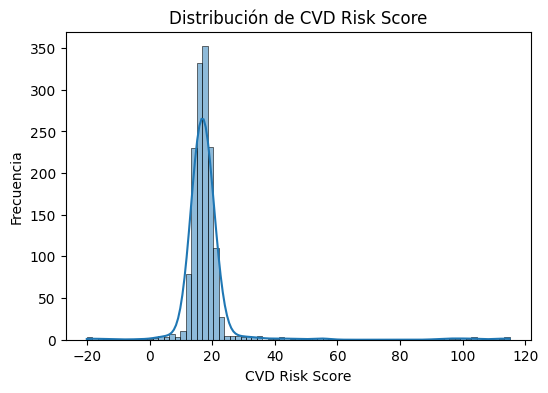

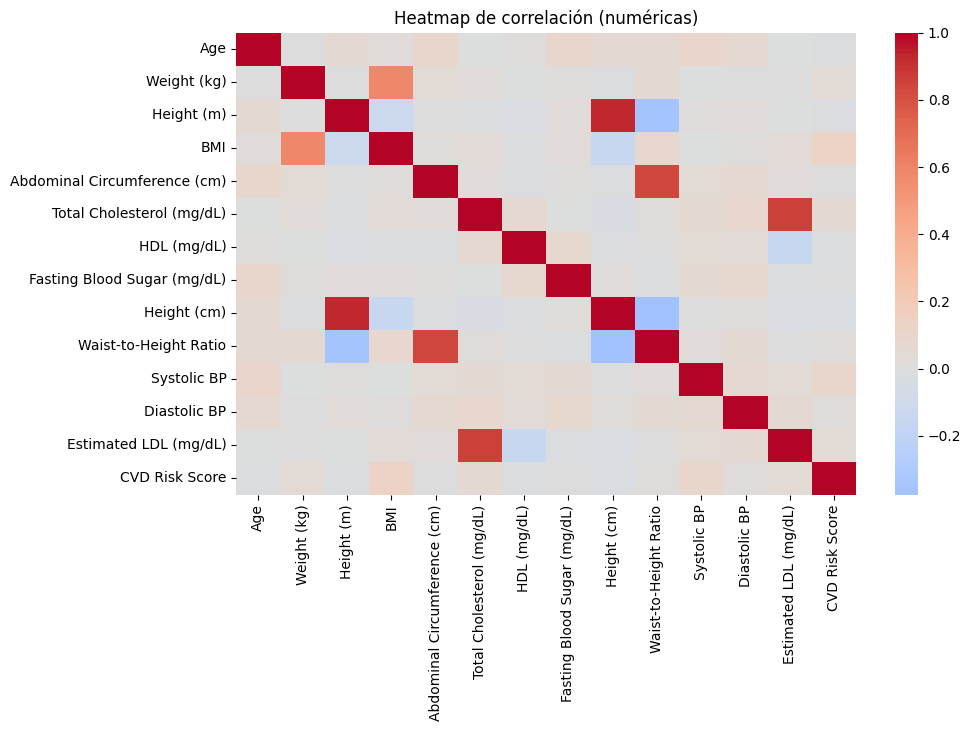

BMI                          0.124398
Systolic BP                  0.092954
Total Cholesterol (mg/dL)    0.055598
Weight (kg)                  0.043229
Estimated LDL (mg/dL)        0.041459
Height (cm)                  0.024762
Diastolic BP                 0.022924
Waist-to-Height Ratio        0.022510
Height (m)                   0.019555
Age                          0.013410
Name: CVD Risk Score, dtype: float64

In [30]:

plt.figure(figsize=(6,4))
sns.histplot(train[TARGET], kde=True)
plt.title("Distribución de CVD Risk Score")
plt.xlabel(TARGET)
plt.ylabel("Frecuencia")
plt.show()

corr = train.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Heatmap de correlación (numéricas)")
plt.show()

target_corr = corr[TARGET].drop(TARGET).abs().sort_values(ascending=False)
display(target_corr.head(10))


## 6. Definir X, y y partición train-test (obligatorio del enunciado)

Qué haces:
- Separas X e y.
- Haces `train_test_split` con `random_state=42` y `test_size=0.25`.

Por qué: es una instrucción explícita del enunciado y crea el conjunto test para comparar modelos.


In [31]:

DROP_ALWAYS = ["Patient ID", "Date of Service", AUX_LABEL]

X = train.drop(columns=[TARGET] + DROP_ALWAYS).copy()
y = train[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (1095, 20) X_test: (365, 20)


## 7. Modelos: dos estrategias de preparación (con pipelines)

El enunciado pide al menos 2 modelos con preparación distinta.

Modelo 1 (baseline)
- Imputación + OHE
- Sin escalado numérico
- Sin ingeniería adicional

Modelo 2 (mejorado)
- Ingeniería de características simple (lineal)
  - Pulse Pressure = Systolic BP - Diastolic BP
  - Chol/HDL = Total Cholesterol / HDL
  - LDL/HDL = Estimated LDL / HDL
- Escalado numérico (StandardScaler)

Ambos modelos usan `Pipeline` como en `RegresionLineal.ipynb`.


In [32]:

class FeatureEngineer(BaseEstimator, TransformerMixin):
    # Transformer scikit-learn que recibe DataFrame y devuelve DataFrame con columnas extra.
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        if "Systolic BP" in X.columns and "Diastolic BP" in X.columns:
            X["Pulse Pressure"] = X["Systolic BP"] - X["Diastolic BP"]

        if "Total Cholesterol (mg/dL)" in X.columns and "HDL (mg/dL)" in X.columns:
            X["Chol/HDL"] = X["Total Cholesterol (mg/dL)"] / X["HDL (mg/dL)"]

        if "Estimated LDL (mg/dL)" in X.columns and "HDL (mg/dL)" in X.columns:
            X["LDL/HDL"] = X["Estimated LDL (mg/dL)"] / X["HDL (mg/dL)"]

        return X

def build_preprocess(X_sample: pd.DataFrame, scale_numeric: bool) -> ColumnTransformer:
    num_cols = X_sample.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols_local = [c for c in X_sample.columns if c not in num_cols]

    num_steps = [("imputer", SimpleImputer(strategy="median"))]
    if scale_numeric:
        num_steps.append(("scaler", StandardScaler()))

    preprocess = ColumnTransformer(
        transformers=[
            ("num", Pipeline(num_steps), num_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first")),
            ]), cat_cols_local),
        ],
        remainder="drop"
    )
    return preprocess

# Modelo 1
preprocess_1 = build_preprocess(X_train, scale_numeric=False)
model_1 = Pipeline([
    ("preprocess", preprocess_1),
    ("reg", LinearRegression()),
])

# Modelo 2
X_train_fe = FeatureEngineer().transform(X_train)
preprocess_2 = build_preprocess(X_train_fe, scale_numeric=True)
model_2 = Pipeline([
    ("fe", FeatureEngineer()),
    ("preprocess", preprocess_2),
    ("reg", LinearRegression()),
])


## 8. Entrenar y evaluar los 2 modelos (RMSE, MAE, R2)

Qué haces:
- Entrenas en `X_train, y_train`.
- Predices en `X_test`.
- Calculas RMSE, MAE, R2 y construyes una tabla comparativa.

Por qué: corresponde a la evaluación cuantitativa del enunciado.


In [33]:

def evaluate(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)

    rmse = np.sqrt(mean_squared_error(y_te, pred))
    mae  = mean_absolute_error(y_te, pred)
    r2   = r2_score(y_te, pred)

    return rmse, mae, r2

rmse1, mae1, r21 = evaluate(model_1, X_train, y_train, X_test, y_test)
rmse2, mae2, r22 = evaluate(model_2, X_train, y_train, X_test, y_test)

results = pd.DataFrame([
    {"Modelo": "Modelo 1 (baseline)", "RMSE": rmse1, "MAE": mae1, "R2": r21},
    {"Modelo": "Modelo 2 (feat eng + scaler)", "RMSE": rmse2, "MAE": mae2, "R2": r22},
]).sort_values("RMSE", ascending=True)

display(results)

best_model_name = results.iloc[0]["Modelo"]
best_model = model_1 if best_model_name.startswith("Modelo 1") else model_2
print("Mejor modelo por RMSE:", best_model_name)


/Users/pablogalindo/Desktop/UNIVERSIDAD/NOVENO SEMESTRE/MACHINE LEARNING/MaterialDeClase-ISIS-2611/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/Users/pablogalindo/Desktop/UNIVERSIDAD/NOVENO SEMESTRE/MACHINE LEARNING/MaterialDeClase-ISIS-2611/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


,Modelo,RMSE,MAE,R2
0,Modelo 1 (baseline),11.841994,5.572296,-0.204690
1,Modelo 2 (feat eng + scaler),12.146656,6.298658,-0.267474


Mejor modelo por RMSE: Modelo 1 (baseline)


## 9. Interpretación del mejor modelo: coeficientes e importancia de variables

Qué haces:
- Extraes nombres de variables post preprocesamiento.
- Extraes coeficientes del regresor.
- Ordenas por valor absoluto.

Por qué: el enunciado exige coeficientes e importancia de variables.


In [34]:

best_model.fit(X_train, y_train)

preprocess_step = best_model.named_steps["preprocess"]
feature_names = preprocess_step.get_feature_names_out()
coefs = best_model.named_steps["reg"].coef_

coef_df = (
    pd.DataFrame({"Feature": feature_names, "Coef": coefs})
      .assign(AbsCoef=lambda d: d["Coef"].abs())
      .sort_values("AbsCoef", ascending=False)
)

display(coef_df.head(25))


,Feature,Coef,AbsCoef
520,cat__Blood Pressure (mmHg)_139/64,101.945106,101.945106
47,cat__Blood Pressure (mmHg)_102/90,94.540940,94.540940
101,cat__Blood Pressure (mmHg)_106/83,91.121159,91.121159
303,cat__Blood Pressure (mmHg)_123/72,90.605546,90.605546
504,cat__Blood Pressure (mmHg)_137/84,90.511378,90.511378
605,cat__Blood Pressure (mmHg)_144/93,88.287042,88.287042
580,cat__Blood Pressure (mmHg)_143/64,84.315074,84.315074
354,cat__Blood Pressure (mmHg)_126/89,78.730868,78.730868
751,cat__Blood Pressure (mmHg)_167/83,77.847392,77.847392
861,cat__Blood Pressure (mmHg)_95/87,76.056469,76.056469


## 10. Verificación de supuestos (gráficos)

Qué haces:
- Residuos vs predicción: homocedasticidad y linealidad (visual).
- Histograma y QQ-plot: normalidad aproximada de errores.

Por qué: el enunciado pide validar supuestos para interpretación.


/Users/pablogalindo/Desktop/UNIVERSIDAD/NOVENO SEMESTRE/MACHINE LEARNING/MaterialDeClase-ISIS-2611/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


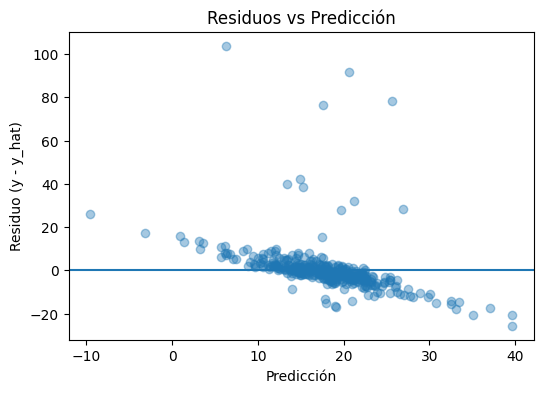

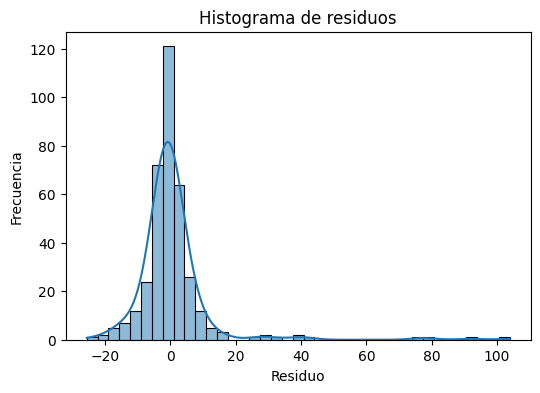

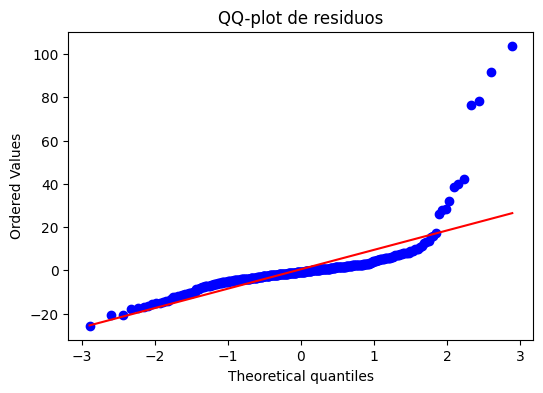

In [35]:

y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0)
plt.title("Residuos vs Predicción")
plt.xlabel("Predicción")
plt.ylabel("Residuo (y - y_hat)")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Histograma de residuos")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.show()

import scipy.stats as stats
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-plot de residuos")
plt.show()


### 10.1 Pruebas estadísticas opcionales (statsmodels)

Si quieres replicar el rigor de `RegresionLineal.ipynb`, instala statsmodels:
`pip install statsmodels`

Esta celda:
- Durbin-Watson: independencia aproximada
- Breusch-Pagan: homocedasticidad
- VIF: multicolinealidad


In [36]:

try:
    import statsmodels.api as sm
    from statsmodels.stats.diagnostic import het_breuschpagan
    from statsmodels.stats.stattools import durbin_watson
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    Xt_test = preprocess_step.transform(X_test)
    Xt_test_arr = Xt_test.toarray() if hasattr(Xt_test, "toarray") else Xt_test
    Xt_test_df = pd.DataFrame(Xt_test_arr, columns=feature_names, index=X_test.index)

    X_sm = sm.add_constant(Xt_test_df)
    model_sm = sm.OLS(y_test, X_sm).fit()

    dw = durbin_watson(model_sm.resid)
    print("Durbin-Watson:", dw)

    bp_test = het_breuschpagan(model_sm.resid, model_sm.model.exog)
    bp_labels = ["LM Stat", "LM p-value", "F Stat", "F p-value"]
    print("Breusch-Pagan:", dict(zip(bp_labels, bp_test)))

    vif_vals = []
    with np.errstate(divide="ignore", invalid="ignore"):
        for i in range(Xt_test_df.shape[1]):
            vif_vals.append(variance_inflation_factor(Xt_test_df.values, i))

    vif_df = pd.DataFrame({"Feature": feature_names, "VIF": vif_vals}).sort_values("VIF", ascending=False)
    display(vif_df.head(25))

except ImportError:
    print("No se pudo importar statsmodels. Si quieres estas pruebas: pip install statsmodels")


No se pudo importar statsmodels. Si quieres estas pruebas: pip install statsmodels


## 11. Entrenar el mejor modelo con TODO el train y predecir el test no etiquetado

Qué haces:
- Reentrenas con todo el train.
- Predices `CVD Risk Score` para el test.
- Exportas un CSV listo para entregar.

Por qué: es un entregable explícito del enunciado.


In [37]:
# 1) Train completo (ya limpio) para entrenar final
X_full = train.drop(columns=[TARGET] + DROP_ALWAYS).copy()
y_full = train[TARGET].copy()

# 2) Partimos del test ORIGINAL para conservar filas y orden del archivo entregable
test_submit = clean_common(test_raw.copy(), cat_cols)

# 3) Armamos X_submit (sin columnas que no existan) y lo alineamos con X_full
X_submit = test_submit.drop(columns=DROP_ALWAYS, errors="ignore").copy()
X_submit = X_submit.reindex(columns=X_full.columns)

# 4) Entrenar y predecir
best_model.fit(X_full, y_full)
test_pred = best_model.predict(X_submit)

# 5) Exportar el archivo final con el mismo formato del test (separador ;)
out = test_raw.copy()
out[TARGET] = test_pred

output_path = "Datos Test Lab 1.csv"
out.to_csv(output_path, index=False, sep=";")

print("Archivo generado para entrega:", output_path)
display(out.head())


Archivo generado para entrega: Datos Test Lab 1.csv


/Users/pablogalindo/Desktop/UNIVERSIDAD/NOVENO SEMESTRE/MACHINE LEARNING/MaterialDeClase-ISIS-2611/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
0,WYTG8678,1/12/2021,M,44.0,51.936,1.936,36.442,115.755,105/108,107.0,52.0,125.0,Y,Y,Low,N,193.61,0.598,105.0,108.0,Hypertension Stage 2,25.0,16.080197
1,yloc1993,12-25-2020,F,30.0,115.000,1.830,34.300,93.600,139/79,100.0,31.0,125.0,Y,N,Moderate,N,183.00,0.511,139.0,79.0,Hypertension Stage 1,39.0,14.679077
2,DDwq7653,23-sep-21,M,38.0,63.300,1.700,21.900,93.800,93/67,NaN,76.0,73.0,N,Y,High,N,170.00,0.552,93.0,67.0,Normal,182.0,18.622945
3,YTcX6704,3/03/2021,F,58.0,72.300,1.740,23.900,91.600,99/90,208.0,63.0,114.0,N,N,High,N,174.00,0.526,99.0,90.0,Hypertension Stage 2,115.0,12.202903
4,lZLi8935,06-14-2022,M,51.0,57.600,1.810,17.600,100.000,97/84,137.0,48.0,113.0,Y,N,High,N,181.00,0.552,97.0,84.0,Hypertension Stage 1,59.0,15.573887


## 12. Preguntas de análisis de resultados (responde aquí)

Responde directamente las preguntas del enunciado usando tus resultados:
1. Coeficientes del mejor modelo.
2. Mejor rendimiento y cómo interpretar RMSE, MAE y R2.
3. Variables seleccionadas e interpretación en el contexto.
4. Forma matemática de la regresión lineal y método (mínimos cuadrados ordinarios).
5. Dos tipos de sesgo que podrían afectar el resultado.
